**Pada program kali ini, data akan diambil dengan melalui dua cara. Cara pertama adalah dengan menggunakan API coronavirus dan cara kedua adalah pengambilan data csv terbaru melalui https://github.com/CSSEGISandData/COVID-19.**

In [59]:
!pip install coronavirus

In [60]:
!apt-get install libgeos
!apt-get install libgeos-dev

Reading package lists... Done
Building dependency tree       
Reading state information... Done
E: Unable to locate package libgeos
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libgeos-dev is already the newest version (3.6.2-1build2).
0 upgraded, 0 newly installed, 0 to remove and 25 not upgraded.


In [61]:
!pip install https://github.com/matplotlib/basemap/archive/master.zip

  Using cached https://github.com/matplotlib/basemap/archive/master.zip
  Created wheel for basemap: filename=basemap-1.2.1-cp36-cp36m-linux_x86_64.whl size=121756025 sha256=18593d40e0411edfcb5d98741e43c1e27e957f1b33f405b5b29a16fe02043d5a
  Stored in directory: /tmp/pip-ephem-wheel-cache-5znct16e/wheels/98/4a/fc/ce719b75d97e646645c225f3332b1b217536100314922e9572
Successfully built basemap


In [62]:
!pip install pyproj==1.9.6

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.basemap import Basemap
import pandas as pd
from datetime import datetime as dt
from datetime import timedelta as td

%matplotlib inline

import asyncio
import aiohttp

from coronavirus import get_cases

In [0]:
async def getData():
  session = aiohttp.ClientSession()
  cases = await get_cases(session)
  country,confirmed,deaths,recovered,latitude,longitude = [],[],[],[],[],[]
  for case in cases:
    #print(f"Cases in {case.country}: {case.confirmed}")
    #attr of case = id, country, confirmed, deaths, recovered, latitude, longitude, updated
    country.append(case.country)
    confirmed.append(case.confirmed)
    deaths.append(case.deaths)
    recovered.append(case.recovered)
    latitude.append(case.latitude)
    longitude.append(case.longitude)
    await session.close()
  df = pd.DataFrame({"Country":country,"Confirmed":confirmed,"Deaths":deaths,"Recovered":recovered,"Latitude":latitude,"Longitude":longitude})
  return df

In [65]:
  loop = asyncio.get_event_loop()
  dfCovid = loop.run_until_complete(getData())
  dfCovid.head()

,Country,Confirmed,Deaths,Recovered,Latitude,Longitude
0,Canada,1328,19,10,60.0010,-95.0010
1,Maldives,13,0,0,3.2028,73.2207
2,Lithuania,105,1,1,55.1694,23.8813
3,Cambodia,53,0,1,12.5657,104.9910
4,Ethiopia,9,0,4,9.1450,40.4897


In [66]:
dfCovid["Death Rate(%)"] = round((dfCovid["Deaths"]/dfCovid["Confirmed"])*100,2)
dfCovid["Not Recovered"] = dfCovid["Confirmed"] - dfCovid["Recovered"] - dfCovid["Deaths"]
dfCovid.head(3)

,Country,Confirmed,Deaths,Recovered,Latitude,Longitude,Death Rate(%),Not Recovered
0,Canada,1328,19,10,60.0010,-95.0010,1.43,1299
1,Maldives,13,0,0,3.2028,73.2207,0.00,13
2,Lithuania,105,1,1,55.1694,23.8813,0.95,103


In [67]:
df_sort_confirmed = dfCovid.sort_values(["Confirmed"],ascending=False)
df_sort_confirmed = df_sort_confirmed.reset_index(drop=True)
df_sort_confirmed.head(3)

,Country,Confirmed,Deaths,Recovered,Latitude,Longitude,Death Rate(%),Not Recovered
0,China,81394,3265,72361,30.5928,114.3055,4.01,5768
1,Italy,53578,4825,6072,41.8719,12.5674,9.01,42681
2,Spain,28572,1720,2125,40.4637,-3.7492,6.02,24727


In [68]:
df_sort_deathrate = dfCovid.sort_values(["Death Rate(%)"],ascending=False)
df_sort_deathrate = df_sort_deathrate.reset_index(drop=True)
df_sort_deathrate.head(3)

,Country,Confirmed,Deaths,Recovered,Latitude,Longitude,Death Rate(%),Not Recovered
0,Sudan,2,1,0,12.8628,30.2176,50.00,1
1,Gabon,5,1,0,-0.8037,11.6094,20.00,4
2,Guyana,7,1,0,4.8604,-58.9302,14.29,6


**Melakukan plotting terhadap persebaran COVID-19 per negara (Data API coronavirus)**

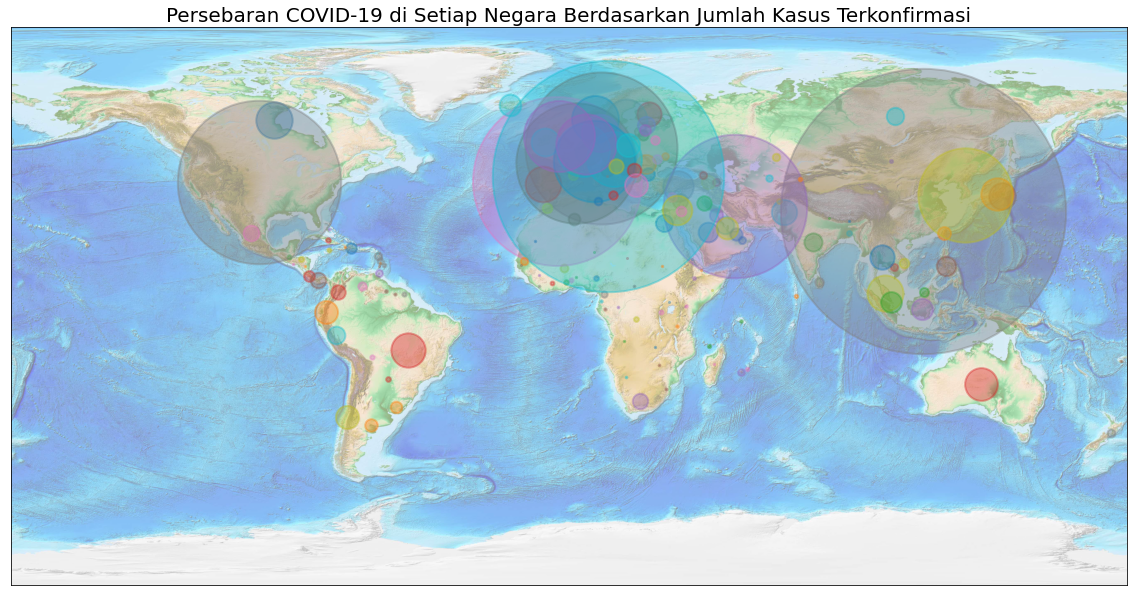

In [69]:
fig = plt.figure(figsize=(20, 20))
m = Basemap(projection='cyl', resolution=None,
            llcrnrlat=-90, urcrnrlat=90,
            llcrnrlon=-180, urcrnrlon=180, )
m.etopo(scale=0.5, alpha=0.5)
plt.title("Persebaran COVID-19 di Setiap Negara Berdasarkan Jumlah Kasus Terkonfirmasi", fontsize='20')
for i in range(int(dfCovid.shape[0])):
  x, y = m(dfCovid.iloc[i:i+1]["Longitude"].values[0], dfCovid.iloc[i:i+1,:]["Latitude"])
  plt.scatter(x, y, s=dfCovid.iloc[i:i+1,:]["Confirmed"].values[0], alpha=0.4, linewidth=2)
  #plt.plot(x, y, 'ok', markersize=2)
  #plt.text(x, y, dfCovid.iloc[i:i+1,:]["Country"].values[0], fontsize=7);

**Melakukan plotting terhadap penderita COVID-19 pada sepuluh negara dengan kasus terkonfirmasi terbanyak**

In [70]:
top_ten_confirmed = df_sort_confirmed.iloc[0:10,:].copy()
top_ten_confirmed = top_ten_confirmed.set_index("Country")
top_ten_confirmed.head() 

,Confirmed,Deaths,Recovered,Latitude,Longitude,Death Rate(%),Not Recovered
Country,,,,,,,
China,81394,3265,72361,30.5928,114.3055,4.01,5768
Italy,53578,4825,6072,41.8719,12.5674,9.01,42681
Spain,28572,1720,2125,40.4637,-3.7492,6.02,24727
US,26747,340,176,40.0000,-100.0000,1.27,26231
Germany,23129,93,239,51.1657,10.4515,0.40,22797


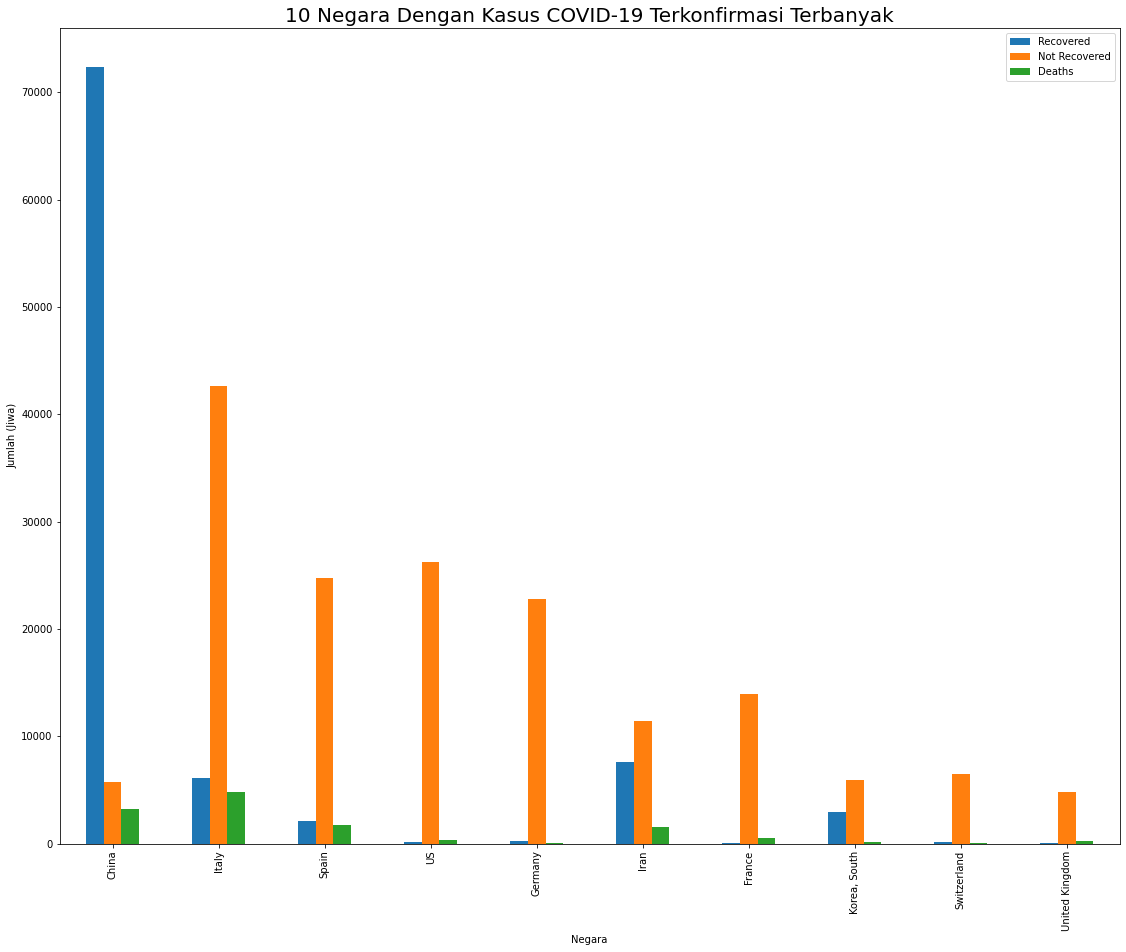

In [71]:
top_ten_confirmed[["Recovered","Not Recovered","Deaths"]].plot.bar(stacked=False)
plt.gcf().set_size_inches(19, 15)
plt.title("10 Negara Dengan Kasus COVID-19 Terkonfirmasi Terbanyak", fontsize = 20)
plt.xlabel("Negara")
plt.ylabel("Jumlah (Jiwa)")
plt.show()

**Melakukan plotting terhadap 10 negara dengan tingkat kematian tertinggi (kasus terkonfirmasi > 1000)**

In [72]:
top_ten_deathrate_thousand = dfCovid[dfCovid["Confirmed"]>1000]
top_ten_deathrate_thousand = top_ten_deathrate_thousand.sort_values(["Death Rate(%)"], ascending=False)
top_ten_deathrate_thousand = top_ten_deathrate_thousand.iloc[0:10,:].copy()
top_ten_deathrate_thousand = top_ten_deathrate_thousand.set_index("Country")
top_ten_deathrate_thousand.head() 

,Confirmed,Deaths,Recovered,Latitude,Longitude,Death Rate(%),Not Recovered
Country,,,,,,,
Italy,53578,4825,6072,41.8719,12.5674,9.01,42681
Iran,20610,1556,7635,32.4279,53.6880,7.55,11419
Spain,28572,1720,2125,40.4637,-3.7492,6.02,24727
United Kingdom,5067,234,67,55.0000,-3.0000,4.62,4766
China,81394,3265,72361,30.5928,114.3055,4.01,5768


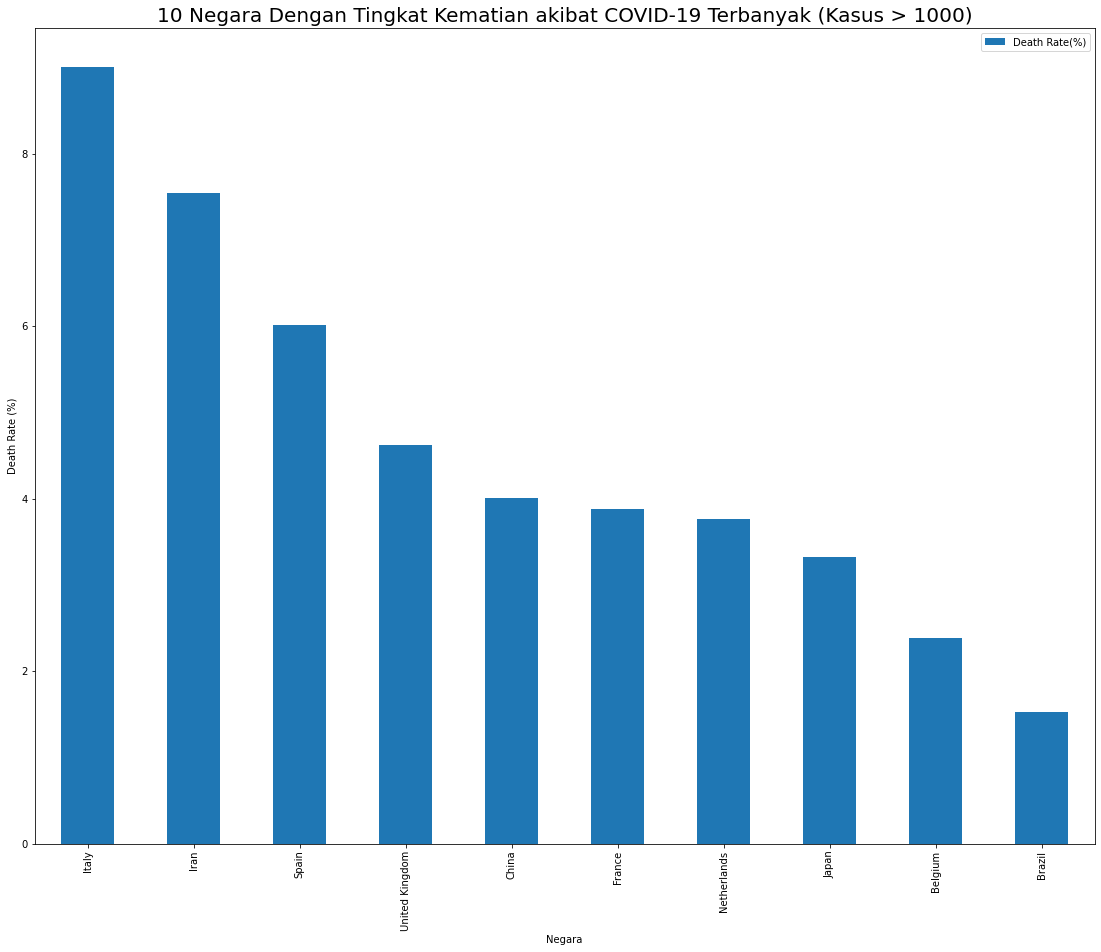

In [73]:
top_ten_deathrate_thousand[["Death Rate(%)"]].plot.bar()
plt.gcf().set_size_inches(19, 15)
plt.title("10 Negara Dengan Tingkat Kematian akibat COVID-19 Terbanyak (Kasus > 1000)", fontsize = 20)
plt.xlabel("Negara")
plt.ylabel("Death Rate (%)")
plt.show()

**Melakukan plotting terhadap persebaran COVID-19 per provinsi (Data https://github.com/CSSEGISandData/COVID-19)**

In [0]:
date = str(dt.strftime(dt.now() - td(1), '%m-%d-%Y'))

In [0]:
url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/"+date+".csv"

In [0]:
CovDetail = pd.read_csv(url)

In [77]:
CovDetail.head(3)

,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered,Latitude,Longitude
0,Hubei,China,2020-03-21T10:13:08,67800,3139,58946,30.9756,112.2707
1,NaN,Italy,2020-03-21T17:43:03,53578,4825,6072,41.8719,12.5674
2,NaN,Spain,2020-03-21T13:13:30,25374,1375,2125,40.4637,-3.7492


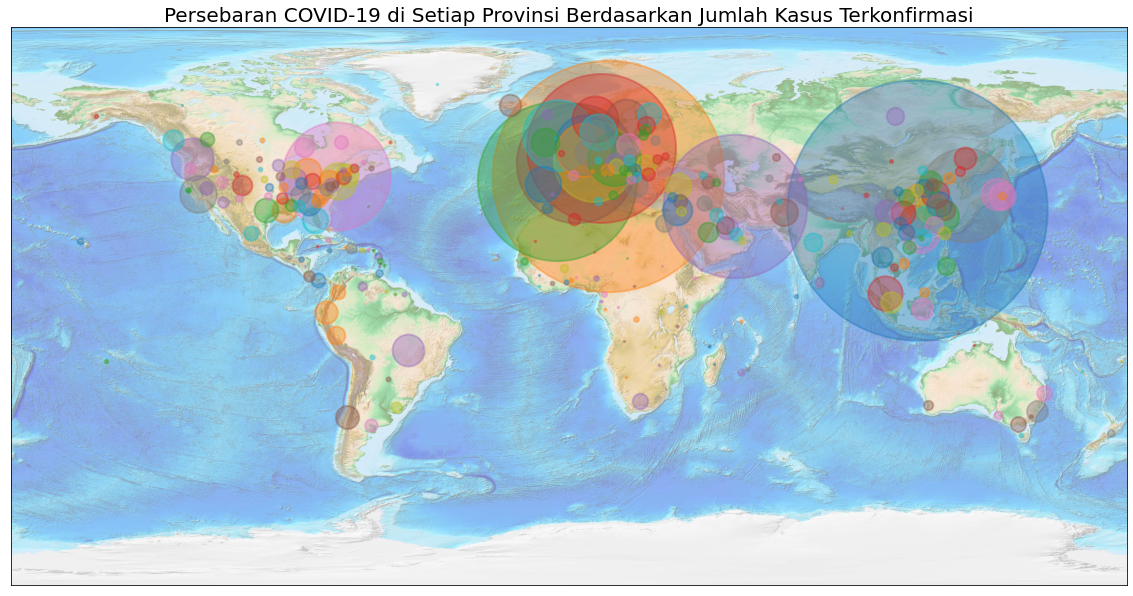

In [78]:
fig = plt.figure(figsize=(20, 20))
m = Basemap(projection='cyl', resolution=None,
            llcrnrlat=-90, urcrnrlat=90,
            llcrnrlon=-180, urcrnrlon=180, )
m.etopo(scale=0.5, alpha=0.5)
plt.title("Persebaran COVID-19 di Setiap Provinsi Berdasarkan Jumlah Kasus Terkonfirmasi", fontsize='20')
for i in range(int(CovDetail.shape[0])):
  x, y = m(CovDetail.iloc[i:i+1]["Longitude"].values[0], CovDetail.iloc[i:i+1,:]["Latitude"])
  plt.scatter(x, y, s=CovDetail.iloc[i:i+1,:]["Confirmed"].values[0], alpha=0.4, linewidth=2)
  #plt.plot(x, y, 'ok', markersize=2)
  #plt.text(x, y, CovDetail.iloc[i:i+1,:]["Country/Region"].values[0], fontsize=7);

In [81]:
CovDetail["Last Update"]= CovDetail["Last Update"].str.slice(0, 10, 1)
CovDetail.head()  

,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered,Latitude,Longitude
0,Hubei,China,2020-03-21,67800,3139,58946,30.9756,112.2707
1,NaN,Italy,2020-03-21,53578,4825,6072,41.8719,12.5674
2,NaN,Spain,2020-03-21,25374,1375,2125,40.4637,-3.7492
3,NaN,Germany,2020-03-21,22213,84,233,51.1657,10.4515
4,NaN,Iran,2020-03-21,20610,1556,7635,32.4279,53.6880


**Grafik Time-Series suatu negara terhadap kasus terkonfirmasi, kematian, dan kesembuhan pada COVID-19 (Data https://github.com/CSSEGISandData/COVID-19)**

In [0]:
dfConfirmedTimeSeries = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv")
dfDeathsTimeSeries = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv")
dfRecoveredTimeSeries = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv")

In [116]:
dfConfTS = pd.DataFrame(dfConfirmedTimeSeries.groupby("Country/Region")[dfConfirmedTimeSeries.columns[list(dfConfirmedTimeSeries.columns).index("Long")+1:]].sum())
dfConfTS = dfConfTS.reset_index(drop=False)
dfConfTS.sort_values(dfConfTS.columns[-1],ascending=False).head(3)

,Country/Region,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20
33,China,548,643,920,1406,2075,2877,5509,6087,8141,9802,11891,16630,19716,23707,27440,30587,34110,36814,39829,42354,44386,44759,59895,66358,68413,70513,72434,74211,74619,75077,75550,77001,77022,77241,77754,78166,78600,78928,79356,79932,80136,80261,80386,80537,80690,80770,80823,80860,80887,80921,80932,80945,80977,81003,81033,81058,81102,81156,81250,81305
79,Italy,0,0,0,0,0,0,0,0,0,2,2,2,2,2,2,2,3,3,3,3,3,3,3,3,3,3,3,3,3,3,20,62,155,229,322,453,655,888,1128,1694,2036,2502,3089,3858,4636,5883,7375,9172,10149,12462,12462,17660,21157,24747,27980,31506,35713,41035,47021,53578
155,US,1,1,2,2,5,5,5,5,5,7,8,8,11,11,11,11,11,11,11,11,12,12,13,13,13,13,13,13,13,13,15,15,15,51,51,57,58,60,68,74,98,118,149,217,262,402,518,583,959,1281,1663,2179,2727,3499,4632,6421,7783,13677,19100,25489


In [117]:
dfDeathTS = pd.DataFrame(dfDeathsTimeSeries.groupby("Country/Region")[dfDeathsTimeSeries.columns[list(dfDeathsTimeSeries.columns).index("Long")+1:]].sum())
dfDeathTS = dfDeathTS.reset_index(drop=False)
dfDeathTS.sort_values(dfDeathTS.columns[-1],ascending=False).head(3)

,Country/Region,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20
79,Italy,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,3,7,10,12,17,21,29,34,52,79,107,148,197,233,366,463,631,827,827,1266,1441,1809,2158,2503,2978,3405,4032,4825
33,China,17,18,26,42,56,82,131,133,171,213,259,361,425,491,563,633,718,805,905,1012,1112,1117,1369,1521,1663,1766,1864,2003,2116,2238,2238,2443,2445,2595,2665,2717,2746,2790,2837,2872,2914,2947,2983,3015,3044,3072,3100,3123,3139,3161,3172,3180,3193,3203,3217,3230,3241,3249,3253,3259
75,Iran,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,4,5,8,12,16,19,26,34,43,54,66,77,92,107,124,145,194,237,291,354,429,514,611,724,853,988,1135,1284,1433,1556


In [118]:
dfRecovTS = pd.DataFrame(dfRecoveredTimeSeries.groupby("Country/Region")[dfRecoveredTimeSeries.columns[list(dfRecoveredTimeSeries.columns).index("Long")+1:]].sum())
dfRecovTS = dfRecovTS.reset_index(drop=False)
dfRecovTS.sort_values(dfRecovTS.columns[-1],ascending=False).head(3)

,Country/Region,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20
33,China,28,30,36,39,49,58,101,120,135,214,275,463,614,843,1115,1477,1999,2596,3219,3918,4636,5082,6217,7977,9298,10755,12462,14206,15962,18014,18704,22699,23187,25015,27676,30084,32930,36329,39320,42162,44854,47450,50001,52292,53944,55539,57388,58804,60181,61644,62901,64196,65660,67017,67910,68798,69755,70535,71266,71857
75,Iran,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,49,49,73,123,175,291,291,552,739,913,1669,2134,2394,2731,2959,2959,2959,2959,4590,4590,5389,5389,5710,6745,7635
79,Italy,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,1,1,3,45,46,46,83,149,160,276,414,523,589,622,724,724,1045,1045,1439,1966,2335,2749,2941,4025,4440,4440,6072


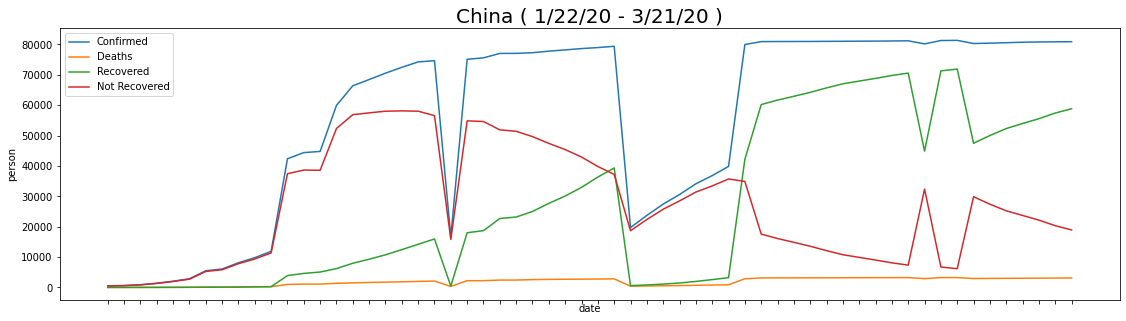

In [164]:
Country = "China"
liConf = list(dfConfTS[dfConfTS["Country/Region"]==Country].values[0][1:])
liDeath = list(dfDeathTS[dfDeathTS["Country/Region"]==Country].values[0][1:])
liRecov = list(dfRecovTS[dfRecovTS["Country/Region"]==Country].values[0][1:])
liNotRecov = list(np.array(liConf)-np.array(liDeath)-np.array(liRecov))
ax = sns.lineplot(x=list(dfConfTS.columns[1:]), y=liConf, label="Confirmed")
ax = sns.lineplot(x=list(dfDeathTS.columns[1:]), y=liDeath, label="Deaths")
ax = sns.lineplot(x=list(dfRecovTS.columns[1:]), y=liRecov, label="Recovered")
ax = sns.lineplot(x=list(dfRecovTS.columns[1:]), y=liNotRecov, label="Not Recovered")
plt.gcf().set_size_inches(19, 5)
plt.tick_params(labelbottom=False)
plt.title(Country+" ( "+dfConfTS.columns[1]+" - "+dfConfTS.columns[-1]+" )",fontsize=20)
plt.ylabel("person")
plt.xlabel("date")
plt.show()

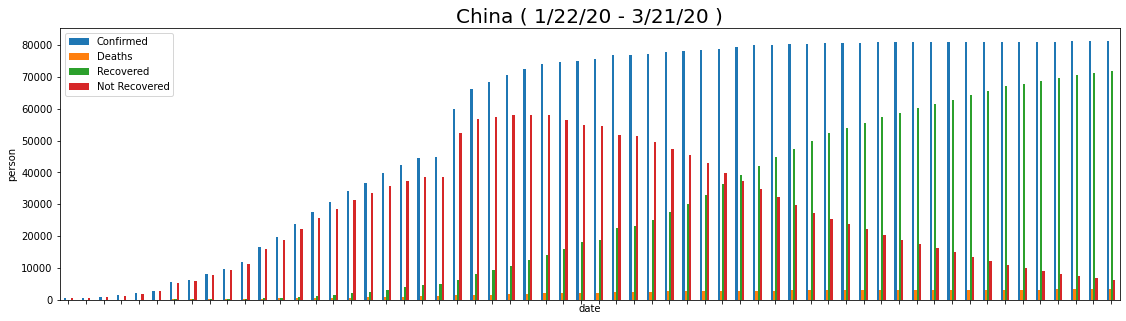

In [163]:
report = pd.DataFrame({"Date":list(dfConfTS.columns[1:]),"Confirmed":liConf,"Deaths":liDeath,"Recovered":liRecov,"Not Recovered":liNotRecov})
report[["Confirmed","Deaths","Recovered","Not Recovered"]].plot.bar(stacked=False)
plt.gcf().set_size_inches(19, 5)
plt.tick_params(labelbottom=False)
plt.title(Country+" ( "+dfConfTS.columns[1]+" - "+dfConfTS.columns[-1]+" )",fontsize=20)
plt.ylabel("person")
plt.xlabel("date")
plt.show()